In [1]:
import numpy as np
import pandas as pd
import itertools
import statsmodels.api as sm
from statsmodels.regression.mixed_linear_model import MixedLM
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import silhouette_score
from sklearn.cluster import DBSCAN, HDBSCAN, MiniBatchKMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import kneighbors_graph
from sklearn.cluster import SpectralClustering

In [ ]:
from data_load import Data
load = Data()
load.HOMES_FOR_SALE()
load.INCOME()
load.HOMICIDES()
load.POPULATION()
load.ZIP_COUNTY()

c:\Users\elang\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loading: C:\Users\elang\.cache\kagglehub\datasets\ahmedshahriarsakib\usa-real-estate-dataset\versions\25\realtor-data.zip.csv
200 https://www.huduser.gov/hudapi/public/usps?type=2&query=All


In [3]:
from Final_Data_Output import Final_Data as FD
FD = FD()
clean_df = FD.Merge_all()
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1067103 entries, 3 to 1084908
Data columns (total 12 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   bed                 1067103 non-null  float64
 1   bath                1067103 non-null  float64
 2   house_size          1067103 non-null  float64
 3   acre_lot            1067103 non-null  float64
 4   zip_code            1067103 non-null  float64
 5   Household_AGI       1067103 non-null  float64
 6   Total_Pop           1067103 non-null  float64
 7   Homicides           1067103 non-null  float64
 8   bed_bath_ratio      1067103 non-null  float64
 9   economic_health     1067103 non-null  float64
 10  lot_to_house_ratio  1067103 non-null  float64
 11  log_price           1067103 non-null  float64
dtypes: float64(12)
memory usage: 105.8 MB


In [5]:
clean_df = clean_df.dropna()
clean_df = sm.add_constant(clean_df)
clean_df.shape

(1067103, 13)

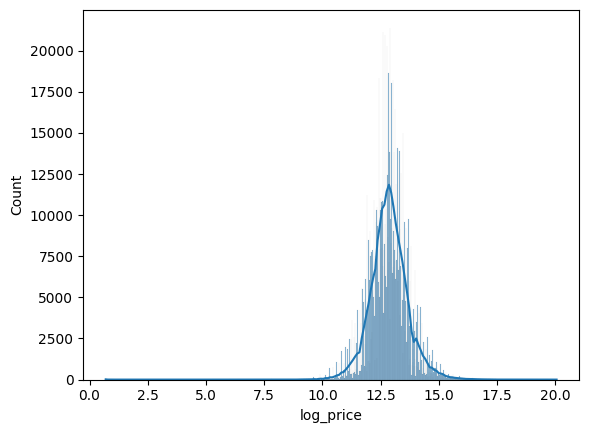

In [6]:
sns.histplot(clean_df['log_price'], kde=True)
plt.show()

In [7]:
clean_df.corr()

,const,bed,bath,house_size,acre_lot,zip_code,Household_AGI,Total_Pop,Homicides,bed_bath_ratio,economic_health,lot_to_house_ratio,log_price
const,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
bed,NaN,1.000000,0.686180,0.236810,-0.000269,-0.034088,0.078326,0.056313,0.000711,0.237313,0.002761,-0.002743,0.305315
bath,NaN,0.686180,1.000000,0.312736,-0.001438,-0.010857,0.259209,0.059375,0.038447,-0.423117,0.033803,-0.002992,0.514942
house_size,NaN,0.236810,0.312736,1.000000,-0.000040,-0.009156,0.115988,0.002658,-0.002350,-0.081794,0.023090,-0.001769,0.219040
acre_lot,NaN,-0.000269,-0.001438,-0.000040,1.000000,-0.006026,-0.002003,-0.002110,-0.001419,0.001323,0.000810,0.575637,-0.002790
zip_code,NaN,-0.034088,-0.010857,-0.009156,-0.006026,1.000000,0.052735,0.201850,0.274407,-0.064948,-0.035825,-0.001406,0.233255
Household_AGI,NaN,0.078326,0.259209,0.115988,-0.002003,0.052735,1.000000,-0.063915,0.096349,-0.201302,0.234907,-0.001579,0.483626
Total_Pop,NaN,0.056313,0.059375,0.002658,-0.002110,0.201850,-0.063915,1.000000,0.232397,-0.036375,-0.243529,-0.000256,0.144645
Homicides,NaN,0.000711,0.038447,-0.002350,-0.001419,0.274407,0.096349,0.232397,1.000000,-0.049278,-0.046995,-0.000111,0.156570
bed_bath_ratio,NaN,0.237313,-0.423117,-0.081794,0.001323,-0.064948,-0.201302,-0.036375,-0.049278,1.000000,-0.024415,-0.000081,-0.284531


In [8]:
X_train, X_test, y_train, y_test = train_test_split(clean_df[['const','bed', 'bath', 'house_size', 'acre_lot', 'zip_code', 'Household_AGI', 
                                                        'Total_Pop', 'Homicides']], clean_df[['log_price']], test_size=0.33, random_state=42)
X_train_fe = X_train[['const','bed', 'bath', 'house_size', 'acre_lot',
                                      'Household_AGI', 'Total_Pop', 'Homicides']]
exog_re = X_train[['const','bed', 'bath', 'house_size', 'acre_lot',
                                   'Household_AGI', 'Total_Pop', 'Homicides']]
exog_re = np.ones((len(X_train), 1))

In [9]:
mod = sm.MixedLM(y_train, X_train_fe, X_train['zip_code'], exog_re=exog_re)
result = mod.fit()
print(result.summary())

          Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: log_price   
No. Observations: 714959  Method:             REML        
No. Groups:       21750   Scale:              0.1597      
Min. group size:  1       Log-Likelihood:     -391546.2171
Max. group size:  722     Converged:          Yes         
Mean group size:  32.9                                    
----------------------------------------------------------
              Coef.  Std.Err.    z     P>|z| [0.025 0.975]
----------------------------------------------------------
const         11.444    0.007 1708.915 0.000 11.431 11.457
bed            0.044    0.001   79.656 0.000  0.043  0.046
bath           0.194    0.001  339.713 0.000  0.193  0.195
house_size     0.000    0.000   74.415 0.000  0.000  0.000
acre_lot       0.000    0.000    0.713 0.476 -0.000  0.000
Household_AGI  0.004    0.000   84.186 0.000  0.004  0.004
Total_Pop      0.000    0.000   38.237 0.000  0.000  0.000
Homicide

In [11]:
re = pd.DataFrame(result.random_effects).T.reset_index()
re.columns = ['zip_code', 'random_effect']
temp_df = X_test[['zip_code']].merge(re, on='zip_code', how='left')

In [12]:
exog = X_test[['const', 'bed', 'bath', 'house_size', 'acre_lot',
               'Household_AGI', 'Total_Pop', 'Homicides']]
groups = X_test['zip_code']
y_pred_mixed = result.predict(exog=exog)+ temp_df['random_effect'].values
R_squared = 1 - np.sum((y_test['log_price'] - y_pred_mixed) ** 2) / np.sum((y_test['log_price'] - np.mean(y_test['log_price'])) ** 2)
print(f'Proportion of Variance Explained: {R_squared:.4f}')

Proportion of Variance Explained: 0.7148


In [13]:
perm_df = pd.DataFrame()
zips = list(clean_df['zip_code'].unique())
for z in zips:
    Household_AGI = clean_df.loc[clean_df['zip_code'] == z, 'Household_AGI'].unique()
    Total_Pop = clean_df.loc[clean_df['zip_code'] == z, 'Total_Pop'].unique()
    Homicides = clean_df.loc[clean_df['zip_code'] == z, 'Homicides'].unique()
    all_permutations = list(itertools.product(Household_AGI, Total_Pop, Homicides, [z]))
    temp_df = pd.DataFrame(all_permutations, columns=['Household_AGI', 'Total_Pop', 'Homicides', 'zip_code'])
    perm_df = pd.concat([perm_df, temp_df], ignore_index=True)
perm_df = perm_df.drop_duplicates().reset_index(drop=True)

In [14]:
def Client_criteria(min_beds=input("Minimum bedrooms you would like:"), max_beds=input("Maximum bedrooms you would like:"), min_baths=input("Minimum bathrooms you would like:"), max_baths=input("Maximum bathrooms you would like:"),
                    min_sqft=input("Minimum square footage you would like:"), max_sqft=input("Maximum square footage you would like:"), min_acre_lot=input("Minimum acreage you would like (acre=sqft/43,560):"), max_acre_lot=input("Maximum acreage you would like (acre=sqft/43,560):")):
    client_data= {'sqft': (min_sqft, max_sqft),
                  'bed': (min_beds, max_beds),
                  'bath': (min_baths, max_baths),
                  'acre_lot': (min_acre_lot, max_acre_lot)}
    return client_data
client_data = Client_criteria()
client_data = pd.DataFrame(client_data).astype(float)

In [15]:
n_smap = 1000000
predict_data = perm_df.sample(n=n_smap, replace=True, random_state=42).reset_index(drop=True)
predict_data['bed'] = np.random.randint(client_data['bed'].min(), client_data['bed'].max()+1, size=n_smap)
predict_data['bath'] = np.random.randint(client_data['bath'].min(), client_data['bath'].max()+1, size=n_smap)
predict_data['house_size'] = np.random.randint(client_data['sqft'].min(), client_data['sqft'].max()+1, size=n_smap)
predict_data['acre_lot'] = np.random.uniform(client_data['acre_lot'].min(), client_data['acre_lot'].max(), size=n_smap).round(2)
predict_data = sm.add_constant(predict_data)
exog_pred = predict_data[['const', 'bed', 'bath', 'house_size', 'acre_lot',
                          'Household_AGI', 'Total_Pop', 'Homicides']]
groups_pred = predict_data['zip_code']
re = pd.DataFrame(result.random_effects).T.reset_index()
re.columns = ['zip_code', 'random_effect']
re_df = predict_data[['zip_code']].merge(re, on='zip_code', how='left')
predict_data['Predicted_Price'] = np.exp(result.predict(exog=exog_pred) + re_df['random_effect'].values)
predict_data['Homicide_Rate'] = predict_data['Homicides'] / predict_data['Total_Pop'] * 100000
predict_data = predict_data.loc[predict_data['Predicted_Price'].notna(),].sort_values(by=['Homicide_Rate','Predicted_Price']).reset_index(drop=True)

In [17]:
predict_data.head(20)

,const,Household_AGI,Total_Pop,Homicides,zip_code,bed,bath,house_size,acre_lot,Predicted_Price,Homicide_Rate
0,1.0,63.95875,2010.0,0.0,67576.0,3,2,2208,0.51,812.204397,0.0
1,1.0,63.95875,2010.0,0.0,67576.0,3,2,2264,0.54,812.780582,0.0
2,1.0,63.95875,2010.0,0.0,67576.0,3,2,2316,0.30,813.315882,0.0
3,1.0,63.95875,2010.0,0.0,67576.0,3,2,2354,0.95,813.707577,0.0
4,1.0,63.95875,2010.0,0.0,67576.0,3,2,2375,0.48,813.923828,0.0
5,1.0,63.95875,2010.0,0.0,67576.0,3,2,2381,0.96,813.985842,0.0
6,1.0,63.95875,2010.0,0.0,67576.0,3,2,2430,0.49,814.490911,0.0
7,1.0,63.95875,2010.0,0.0,67576.0,3,2,2509,0.63,815.306184,0.0
8,1.0,63.95875,2010.0,0.0,67576.0,3,2,2532,0.64,815.543684,0.0
9,1.0,63.95875,2010.0,0.0,67576.0,3,2,2541,0.26,815.636502,0.0
